# Text Analysis of TED Talks transcripts

The data used in this project is available on https://www.kaggle.com/rounakbanik/ted-talks/data

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.snowball import SnowballStemmer
import string
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import json

%matplotlib inline

In [2]:
#Configure plots
rc={'savefig.dpi': 75, 'figure.figsize': [12,8], 'lines.linewidth': 2.0, 'lines.markersize': 8, 'axes.labelsize': 18,\
   'axes.titlesize': 18, 'font.size': 18, 'legend.fontsize': 16, 'xtick.labelsize': 16, 'ytick.labelsize': 16}

sns.set(style='dark',rc=rc)

In [3]:
ted_data = pd.read_csv('data/ted_main.csv')

In [4]:
ted_data.keys()

Index(['comments', 'description', 'duration', 'event', 'film_date',
       'languages', 'main_speaker', 'name', 'num_speaker', 'published_date',
       'ratings', 'related_talks', 'speaker_occupation', 'tags', 'title',
       'url', 'views'],
      dtype='object')

In [5]:
ted_transcripts = pd.read_csv('data/transcripts.csv')

In [6]:
ted_transcripts.head()

,transcript,url
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...


In [7]:
ted_transcripts = ted_transcripts.join(ted_data['title'])

In [8]:
ted_transcripts.head()

,transcript,url,title
0,Good morning. How are you?(Laughter)It's been ...,https://www.ted.com/talks/ken_robinson_says_sc...,Do schools kill creativity?
1,"Thank you so much, Chris. And it's truly a gre...",https://www.ted.com/talks/al_gore_on_averting_...,Averting the climate crisis
2,"(Music: ""The Sound of Silence,"" Simon & Garfun...",https://www.ted.com/talks/david_pogue_says_sim...,Simplicity sells
3,If you're here today — and I'm very happy that...,https://www.ted.com/talks/majora_carter_s_tale...,Greening the ghetto
4,"About 10 years ago, I took on the task to teac...",https://www.ted.com/talks/hans_rosling_shows_t...,The best stats you've ever seen


In [9]:
ted_transcripts.shape

(2467, 3)

Checking for missing data:

In [10]:
pd.isnull(ted_transcripts).sum()

transcript    0
url           0
title         0
dtype: int64

The dataset has two columns: one is the url and the other has the talk transcript. This dataset contains information about 2467 TED Talks.  
To build the first analyses a sample of approximatelly 10% of the data will be used. And only the transcript information will be considered.  

In [11]:
transcripts_sample = ted_transcripts[:250]['transcript']

In [12]:
transcripts_sample.head()

0    Good morning. How are you?(Laughter)It's been ...
1    Thank you so much, Chris. And it's truly a gre...
2    (Music: "The Sound of Silence," Simon & Garfun...
3    If you're here today — and I'm very happy that...
4    About 10 years ago, I took on the task to teac...
Name: transcript, dtype: object

First each transcript will be transformed. Punctuation will be removed and each word will be transformed to lowercase and reduced to its root.

In [14]:
stemmer = SnowballStemmer("english")

def text_transform(text):

    table = str.maketrans('','', string.punctuation)
    text_string = text.translate(table)
    
    words_split = text_string.split()
    words = ""
    for word in words_split:
        words = words + stemmer.stem(word) + " "
    return words  

In [15]:
transcripts_sample = transcripts_sample.apply(text_transform)

The next step will perform tf–idf normalization. It increases the importance of words that appear multiple times in the same document and decreases the importance of terms that appear in many documents.

In [16]:
vectorizer = TfidfVectorizer(stop_words = 'english', max_df=0.5)
data_transformed = vectorizer.fit_transform(transcripts_sample) #modify to the complete dataset later

Number of features:

In [17]:
len(vectorizer.get_feature_names())

21639

In [18]:
map_features = vectorizer.get_feature_names()

The talks will be separated in clusters based on the data from the text analysis. 20 clusters will be created for this sample.

In [19]:
kmeans = KMeans(n_clusters=20, random_state = 0)
pred = kmeans.fit_predict(data_transformed)

In [20]:
len(pred)

250

The text normalization result will be transformed and stored in a dataframe. The indices will be replaced by the words.

In [21]:
coo = data_transformed.tocoo(copy=False)

transcripts_info = pd.DataFrame({'talk': coo.row, 'feature': coo.col, 'score': coo.data}
                    )[['talk', 'feature', 'score']].sort_values(['talk', 'feature']
                     ).reset_index(drop=True)

In [23]:
def feature_name(feature_index):
    return map_features[feature_index]

transcripts_info['feature'] = transcripts_info['feature'].apply(feature_name)

A column will be added with the predictions result, the number of the cluster, for each document.

In [25]:
def cluster_num(document):
    return pred[document]

transcripts_info['cluster'] = transcripts_info['talk'].apply(cluster_num)

In [26]:
transcripts_info.tail(10)

,talk,feature,score,cluster
107963,249,week,0.030811,13
107964,249,whove,0.067757,13
107965,249,wife,0.049603,13
107966,249,window,0.045513,13
107967,249,woman,0.037723,13
107968,249,womenso,0.093581,13
107969,249,won,0.049603,13
107970,249,wow,0.052425,13
107971,249,york,0.039008,13
107972,249,youv,0.084467,13


The most important words of all talks are represented in the following ploots.

In [27]:
grouped_features = transcripts_info.groupby('feature')['score'].sum().sort_values(ascending = False)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14],
 <a list of 15 Text xticklabel objects>)

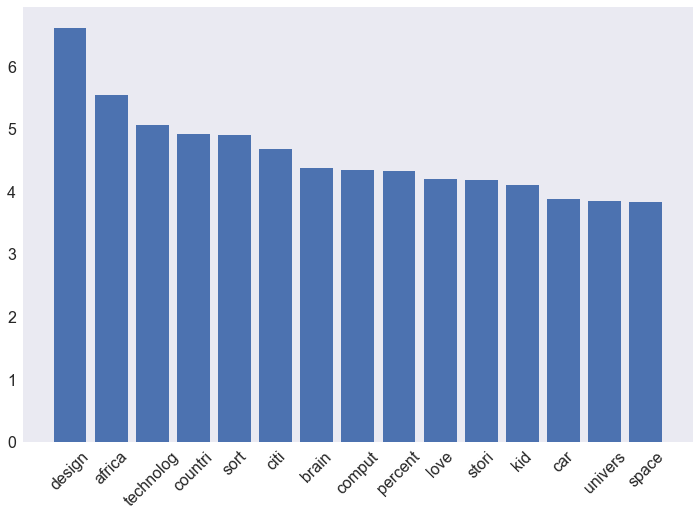

In [28]:
plt.bar(grouped_features.head(15).index, grouped_features.head(15).values)
plt.xticks(rotation=45)

Word Cloud of all talks words.

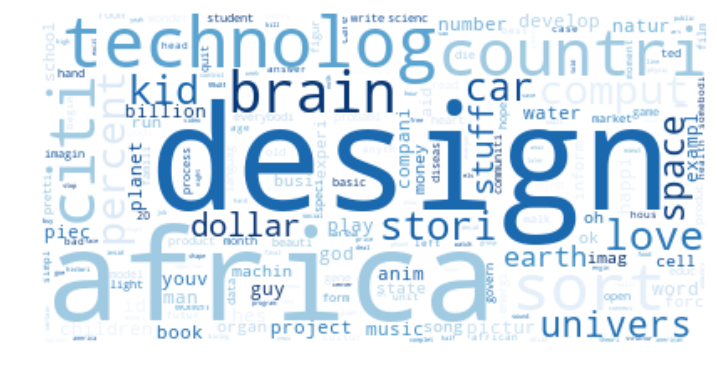

In [29]:
features_dict = grouped_features.to_dict()

wordcloud = WordCloud(background_color='white',
                      #max_words=100,
                      colormap='Blues').generate_from_frequencies(features_dict)
plt.imshow(wordcloud,interpolation="bilinear")
plt.axis('off')
plt.show()

It is interesting for someone looking for a specific subject to receive talks recommendations based on the transcripts. The following code performs this task. It searches for a word and check which talks are most related to it based on the text analysis.

In [30]:
#Key word (edit to search):
key_word = 'lecture'

In [31]:
stem_key_word = stemmer.stem(key_word)

search_feature = transcripts_info[transcripts_info['feature'] == stem_key_word]

rank = search_feature.sort_values('score', ascending = False)

The three most relevant results and url for the searched key word:

In [32]:
relevant_talks = rank['talk'][0:3].values

print (ted_transcripts['title'][relevant_talks[0]], ted_transcripts['url'][relevant_talks[0]]) 
print (ted_transcripts['title'][relevant_talks[1]], ted_transcripts['url'][relevant_talks[1]]) 
print (ted_transcripts['title'][relevant_talks[2]], ted_transcripts['url'][relevant_talks[2]])

My days as a young rebel https://www.ted.com/talks/neil_turok_makes_his_ted_prize_wish

How we discovered DNA https://www.ted.com/talks/al_seckel_says_our_brains_are_mis_wired

A master architect asks, Now what? https://www.ted.com/talks/ben_dunlap_talks_about_a_passionate_life



A force direct graph will be built where the words, talks and clusters can be related.
A sample of three clusters will be used to create a dataset for this graph.

In [33]:
grouped_talks = transcripts_info.groupby(['talk','cluster'], as_index = False).count()

In [34]:
grouped_talks.head()

,talk,cluster,feature,score
0,0,16,549,549
1,1,13,474,474
2,2,12,658,658
3,3,7,763,763
4,4,4,443,443


In [39]:
nodes = []

talks_set = set()
#Saving the talks in nodes
for index, row in grouped_talks.iterrows():
    cluster_num = int(row['cluster'])
    talk_name = ted_transcripts['title'][row['talk']]
    if cluster_num <= 2: #only 3 clusters will be initially saved in the dataset
        item = {}
        #Talk name:
        item['id'] = talk_name
        #Talk cluster:
        item['group'] = cluster_num
        nodes.append(item)  
        talks_set.add(row['talk'])

In [40]:
#Finding the 10 main words for each talk:
def find_main_words(talk_num):
    rank_data = transcripts_info[transcripts_info['talk'] == talk_num].sort_values('score', ascending = False)
    ten_main_words=rank_data['feature'][0:10].values
    return ten_main_words

#Saving the links. Only the ten most relevant words for each talk will be considered.
links = []
main_var_set = set()
for talk_num in talks_set:  
    talk_main_words = find_main_words(talk_num)
    for word in talk_main_words:
        item = {}
        item['source'] = ted_transcripts['title'][talk_num]
        item['target'] = word
        item['value'] = float(transcripts_info['score'][(transcripts_info['talk'] == talk_num) &\
                                                  (transcripts_info['feature'] == word)].values)
        
        links.append(item)
    main_var_set.update(find_main_words(talk_num))

    
#Saving the words in nodes:
for word_name in main_var_set:
    item = {}
    #Word:
    item['id'] = word_name
    #Words are not separated in clusters. The group will be -1.
    item['group'] = -1
    nodes.append(item)

In [41]:
TED_Talk_transcripts = {}
TED_Talk_transcripts['nodes'] = nodes
TED_Talk_transcripts['links'] = links

In [42]:
with open('TED_Talk_transcripts_sample.json', 'w') as outfile:
    json.dump(TED_Talk_transcripts, outfile)

The graph can be checked in this link: https://bl.ocks.org/anandaribeiro/raw/17156a9b99f3f556c497ed5ce28c51f2/
And the code in the gist: https://gist.github.com/anandaribeiro/17156a9b99f3f556c497ed5ce28c51f2

References:  
https://www.kaggle.com/rounakbanik/ted-talks  
https://www.kaggle.com/adelsondias/ted-talks-topic-models  
https://www.kdnuggets.com/2017/06/text-clustering-unstructured-data.html  
https://www.kdnuggets.com/2017/07/text-clustering-unstructured-data-part2.html  
https://www.ted.com/  
https://stackoverflow.com/questions/36587702/convert-sparse-matrix-csc-matrix-to-pandas-dataframe  
https://bl.ocks.org/mbostock/4062045    